# 1. Imports and Setup

Clustering-ի նկարի չափերի փոքրացման հետ կապված էլ կարող եք կարդալ այստեղ - 

- https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf Բաժին 9.1.1

In [1]:
!uv pip install Pillow numpy scikit-learn tqdm

Using Python 3.11.13 environment at: c:\Users\hayk_\OneDrive\Desktop\01_python_math_ml_course\ma
Resolved 8 packages in 4.63s
Installed 1 package in 632ms
 + tqdm==4.67.1


In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from tqdm import tqdm

In [2]:
RESIZE_IMAGE = True
WIDTH = 1_000

# 2. Load and Display the Input Image

Image size: (6000, 4000) | # pixels: 24000000


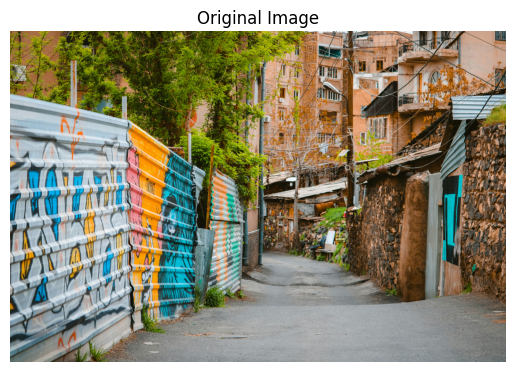

resizing


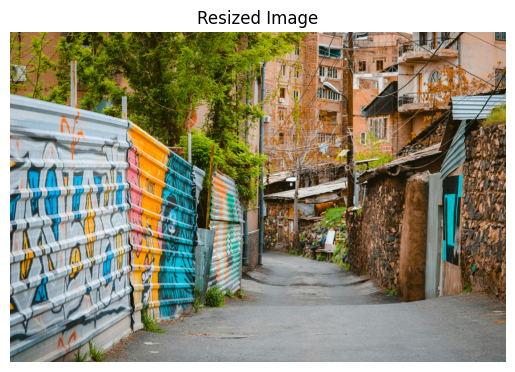

Resized image size: (1000, 666) | # pixels: 666000
Num of unique colors: 280,665


In [24]:
# input_image_path = "sevan.png"
# input_image_path = "Armenia.jpg" # may work poorly with png images
# input_image_path = "Aivazovsky.jpg" # may work poorly with png images
input_image_path = "in/Saryan.jpg"
# input_image_path = "in/08_rainbow.jpg"
input_image_path = "in/libs_03_kond_street_art.jpg"




image = Image.open(input_image_path)

print(f"Image size: {image.size} | # pixels: {image.size[0] * image.size[1]}")

# Display the original image
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')
plt.show()

if RESIZE_IMAGE:
    print("resizing")
    # resize the image but keep the aspect ratio
    width, height = image.size
    aspect_ratio = width / height
    new_width = WIDTH
    new_height = int(new_width / aspect_ratio)

    image = image.resize((new_width, new_height))

    # Display the resized image
    plt.imshow(image)
    plt.title("Resized Image")
    plt.axis('off')
    plt.show()

    print(f"Resized image size: {image.size} | # pixels: {image.size[0] * image.size[1]}")


if input_image_path.endswith(".jpg"):
    print(f"Num of unique colors: {len(set(image.getdata())):,}")

In [25]:
image.getdata()[1]

(160, 103, 60)

# 3. Convert Image to NumPy and Flatten

In [26]:
# Convert PIL image to NumPy array
image_np = np.array(image)

if input_image_path.endswith(".png"):
    height, width = image_np.shape
    num_channels = 3
else:
    height, width, num_channels = image_np.shape
print(f"Original image shape: {image_np.shape}")

# Flatten the image to (num_pixels, num_channels)
pixels = image_np.reshape(-1, num_channels).astype(np.float32)

# Scale pixels from [0, 255] to [0, 1]
pixels /= 255.0
print("Flattened pixels shape:", pixels.shape)
print("Pixel sample:", pixels[0])  # just to see an example pixel


Original image shape: (666, 1000, 3)
Flattened pixels shape: (666000, 3)
Pixel sample: [0.627451   0.4117647  0.25882354]


In [27]:
pixels

array([[0.627451  , 0.4117647 , 0.25882354],
       [0.627451  , 0.40392157, 0.23529412],
       [0.46666667, 0.27450982, 0.09803922],
       ...,
       [0.4       , 0.4392157 , 0.44705883],
       [0.40392157, 0.44313726, 0.4509804 ],
       [0.4117647 , 0.4509804 , 0.45882353]], dtype=float32)

In [28]:
if input_image_path.endswith(".png"):
    print(f"Num of unique colors: {len(set(map(tuple, pixels)))}")

# 4. Evaluate Different Numbers of Clusters

In [29]:
num_clusters_list = [2, 4, 6, 8, 10, 12] # for demo
inertias = [] # sum of squared residuals
silhouette_scores = []
centroids = []

print(len(pixels))

for n_clusters in tqdm(num_clusters_list):
    print(f"Fitting KMeans with {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=509)
    kmeans.fit(pixels)
    
    # Inertia: sum of squared distances to the closest cluster center
    inertia = kmeans.inertia_
    inertias.append(inertia)
    
    # Silhouette Score: measure of how similar each pixel is to its own cluster
    # compared to other clusters. Range: [-1, 1], with 1 = best.
    score = silhouette_score(pixels, kmeans.labels_, sample_size=5000, random_state=509) 
    silhouette_scores.append(score)
    
    # add centroids to list
    centroids.append(kmeans.cluster_centers_)

666000


  0%|          | 0/6 [00:00<?, ?it/s]

Fitting KMeans with 2 clusters...


 17%|█▋        | 1/6 [00:01<00:06,  1.40s/it]

Fitting KMeans with 4 clusters...


 33%|███▎      | 2/6 [00:03<00:06,  1.74s/it]

Fitting KMeans with 6 clusters...


 50%|█████     | 3/6 [00:05<00:05,  1.77s/it]

Fitting KMeans with 8 clusters...


 67%|██████▋   | 4/6 [00:08<00:04,  2.22s/it]

Fitting KMeans with 10 clusters...


 83%|████████▎ | 5/6 [00:10<00:02,  2.32s/it]

Fitting KMeans with 12 clusters...


100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


# 5. Plot Inertia and Silhouette Scores

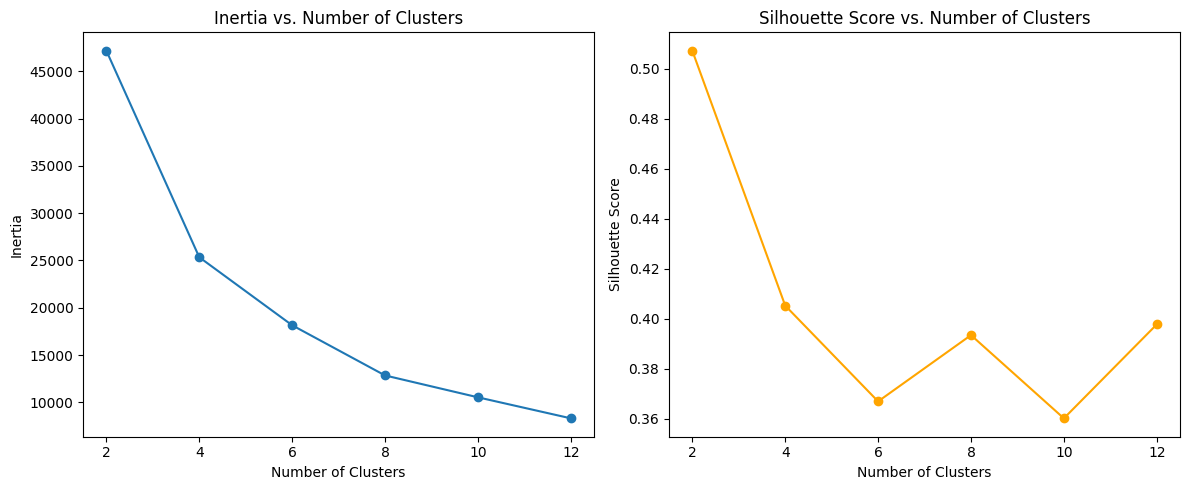

Number of clusters tested: [2, 4, 6, 8, 10, 12]
Inertia: [47172.265625, 25340.74609375, 18150.302734375, 12845.8720703125, 10533.2294921875, 8311.310546875]
Silhouette Scores: [0.5072089433670044, 0.40529322624206543, 0.3669843077659607, 0.39348912239074707, 0.3602153956890106, 0.3977782726287842]


In [30]:
plt.figure(figsize=(12, 5))

# Plot Inertia
plt.subplot(1, 2, 1)
plt.plot(num_clusters_list, inertias, marker='o')
plt.title('Inertia vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(num_clusters_list, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

print("Number of clusters tested:", num_clusters_list)
print("Inertia:", inertias)
print("Silhouette Scores:", silhouette_scores)


# 6. Choose a Number of Clusters and Compress the Image

In [31]:
chosen_n_clusters = 50

# Fit KMeans with the chosen cluster number
kmeans = KMeans(n_clusters=chosen_n_clusters, random_state=42)
kmeans.fit(pixels)

dominant_colors = kmeans.cluster_centers_

dominant_colors_255 = (dominant_colors * 255).astype(np.uint8)

labels = kmeans.labels_
print(labels)
print(len(labels))

compressed_pixels = dominant_colors[labels]
compressed_pixels_255 = dominant_colors_255[labels]

# Reshape to the original dimensions
compressed_image_np = compressed_pixels_255.reshape((height, width, num_channels))

# Convert NumPy array back to PIL image
compressed_image = Image.fromarray(compressed_image_np)


[24 24 13 ... 21 21 21]
666000


# 7. Display the Compressed Image

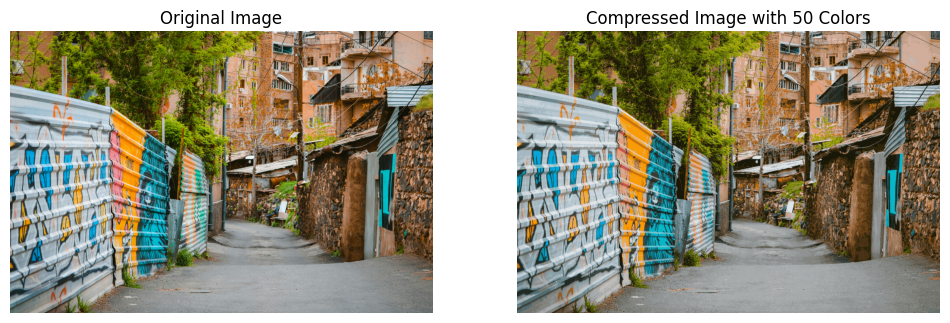

Compressed image saved to out/compressed_libs_03_kond_street_art.jpg


In [32]:
# Display the original and compressed images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original image
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Compressed image
axes[1].imshow(compressed_image)
axes[1].set_title(f"Compressed Image with {chosen_n_clusters} Colors")
axes[1].axis('off')

plt.show()

# Optionally, save it
file_name = f"out/compressed_{input_image_path.split('.')[0].split('/')[1]}.jpg"
compressed_image.save(file_name)
print(f"Compressed image saved to {file_name}")

In [11]:
dominant_colors_255

array([[107, 115, 117],
       [ 24,  42,  49],
       [ 73,  88,  94],
       [125, 145, 149],
       [ 14,  21,  24],
       [239, 193, 113],
       [ 40,  71,  84],
       [ 86,  97, 103],
       [131, 129, 120],
       [ 39,  48,  51],
       [147, 183, 181],
       [ 53,  64,  69],
       [198, 134, 106],
       [ 13,  34,  40],
       [ 99, 109, 113],
       [ 10,  79, 109],
       [ 55,  49,  47],
       [ 66,  81,  88],
       [101,  93,  87],
       [169, 209, 163],
       [123, 120, 111],
       [183, 172, 117],
       [140, 137, 127],
       [  3,   8,   9],
       [142, 172, 134],
       [117, 122, 122],
       [  8,  25,  29],
       [145, 158, 167],
       [ 83,  77,  71],
       [222, 158, 106],
       [ 90, 101, 106],
       [170, 119, 107],
       [ 45,  56,  61],
       [181, 212, 214],
       [ 68, 115, 134],
       [ 80,  93,  99],
       [ 25,  35,  38],
       [123, 131, 134],
       [ 18,  29,  32],
       [ 32,  51,  58],
       [ 24,  59,  73],
       [ 94, 105

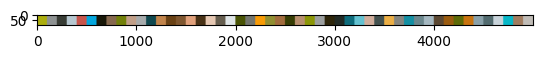

In [33]:
# Display the dominant colors
# just create tiles of the dominant colors  
dominant_colors_image = Image.new("RGB", (chosen_n_clusters * 100, 100))
for i, color in enumerate(dominant_colors_255):
    color_image = Image.new("RGB", (100, 100), color=tuple(color))
    dominant_colors_image.paste(color_image, (i * 100, 0))
    
plt.imshow(dominant_colors_image)


# 8. Compression Ratio

In [34]:
# compare file sizes of the original and compressed images
import os

original_size = os.path.getsize(input_image_path)
compressed_size = os.path.getsize(file_name)

print(f"Original image size: {original_size} bytes")
print(f"Compressed image size: {compressed_size} bytes")
print(f"Compression ratio: {original_size / compressed_size:.2f}")

Original image size: 6443042 bytes
Compressed image size: 185338 bytes
Compression ratio: 34.76


# 9. Color Pallete

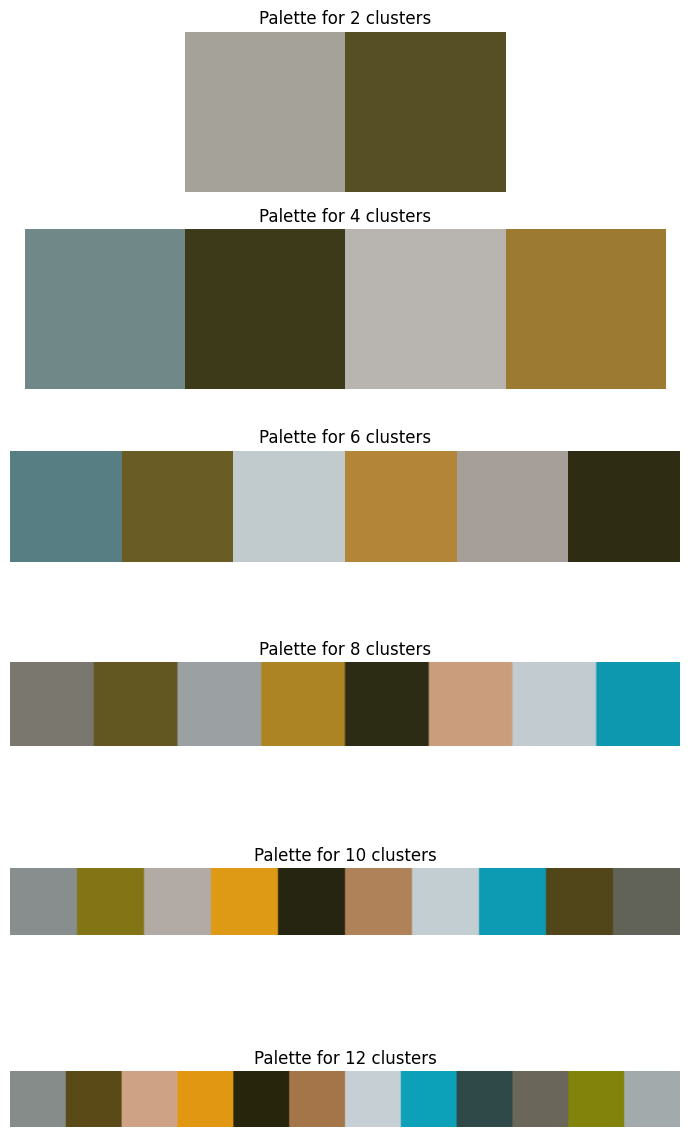

In [35]:
dominant_colors_list = centroids
cluster_counts = [2, 4, 6, 8, 10, 12]

fig, axes = plt.subplots(nrows=len(dominant_colors_list), figsize=(7, 2 * len(dominant_colors_list)))

# If there's only one palette, 'axes' won't be an iterable; ensure it's a list
if len(dominant_colors_list) == 1:
    axes = [axes]

# Loop over each set of cluster centroids and display its palette
for idx, (colors_float, k) in enumerate(zip(dominant_colors_list, cluster_counts)):
    # Convert from [0,1] float to [0,255] uint8
    colors_255 = (colors_float * 255).astype(np.uint8)

    # Create a palette image: width = (#colors * tile_size), height = tile_size
    tile_size = 30
    width = len(colors_255) * tile_size
    palette_img = Image.new("RGB", (width, tile_size))

    # Paste a 100x100 tile for each color
    for i, color in enumerate(colors_255):
        tile = Image.new("RGB", (tile_size, tile_size), color=tuple(color))
        palette_img.paste(tile, (i * tile_size, 0))

    # Display the palette in the corresponding subplot
    axes[idx].imshow(palette_img)
    axes[idx].axis('off')
    axes[idx].set_title(f"Palette for {k} clusters")

plt.tight_layout()
plt.show()